In [1]:
from deepforest import main, visualize
import os
import matplotlib.pyplot as plt
import rasterio
import rasterio

import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import pyproj
import json
from urbantree.setting import Setting
from urbantree.deepforest.detection import infer_images, run_nms, remove_small_overlapping_bbox

In [2]:
SETTING = "settings/opendata_luftbild_dop60_1312/deepforest_r1/setting.yaml"
#SETTING = "settings/opendata_luftbild_dop60_1312/deepforest_r2/setting.yaml"

SETTING = Setting.load_deepforest_setting(SETTING)

In [3]:
# use random images from source images?
USE_RANDOM_SAMPLE = False

if USE_RANDOM_SAMPLE:
  # random sample
  EXAMPLE_DATASET_DIR = Path(SETTING['dataset_img_dir'])
  SAMPLE_TILE_PATHS = np.random.choice(list(EXAMPLE_DATASET_DIR.glob('*.tiff')), 5)
else:
  # or manually specified
  EXAMPLE_DATASET_DIR =  Path('assets/example/{dataset_name}'.format(**SETTING))
  SAMPLE_TILE_PATHS = [
    EXAMPLE_DATASET_DIR.joinpath('1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff')
  ]

# output folder of predict result
EXAMPLE_OUTPUT_DIR =  Path('temp/example/{dataset_name}/{profile_name}/inference/'.format(**SETTING))

# pre-trained model
MODEL_CHECKPOINT = SETTING['model_path']
# model parameter
MODEL_PARAMS_CONFIG     = SETTING['model_params_config']
MODEL_INFERENCE_CONFIG  = SETTING['model_inference_config']

os.makedirs(EXAMPLE_OUTPUT_DIR, exist_ok=True)
print("input:", SAMPLE_TILE_PATHS)
print("output:", EXAMPLE_OUTPUT_DIR)

input: [WindowsPath('assets/example/opendata_luftbild_dop60_1312/1290091.025782968_6132926.158789683_1290874.505322890_6133709.638329607.tiff')]
output: temp\example\opendata_luftbild_dop60_1312\deepforest_r1\inference


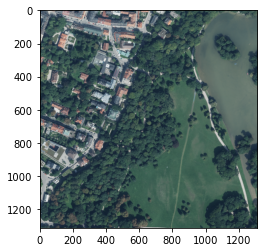

In [4]:
# read and display sample images

sample_images = {}
for SAMPLE_TILE_PATH in SAMPLE_TILE_PATHS:
  with rasterio.open(SAMPLE_TILE_PATH) as src:
    image_crs = src.crs
    image_transform = src.transform
  sample_image = np.array(Image.open(SAMPLE_TILE_PATH).convert("RGB")).astype("uint8")
  sample_images[SAMPLE_TILE_PATH] = { 
    'image': sample_image, 
    'transform': image_transform,
    'crs': image_crs
  }
  plt.imshow(sample_image)
  plt.show()

In [5]:
infer_images(model_path=MODEL_CHECKPOINT, 
             model_params_config=MODEL_PARAMS_CONFIG, 
             model_inference_config=MODEL_INFERENCE_CONFIG,
             dataset_img_list=SAMPLE_TILE_PATHS, 
             dataset_inference_dir=EXAMPLE_OUTPUT_DIR,
             dataset_img_pattern="*.tiff",
             continue_mode=False, use_gpu=True, prefer_model_params_config=False)


Loading pretrained mode: interim/opendata_luftbild_dop60_1312/deepforest_r1/model//model.ckpt
Inference result: temp\example\opendata_luftbild_dop60_1312\deepforest_r1\inference\b
Reading config file: d:\projects\map-urban-trees\deepforest\deepforest\data\deepforest_config.yml
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0
Reading config file: d:\projects\map-urban-trees\deepforest\deepforest\data\deepforest_config.yml


  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\tsunghan.lin\Miniconda3\envs\deepforest\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


285 predictions in overlapping windows, applying non-max supression
130 predictions kept after non-max suppression


100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


424 predictions in overlapping windows, applying non-max supression
285 predictions kept after non-max suppression


100%|██████████| 64/64 [00:19<00:00,  3.26it/s]


1683 predictions in overlapping windows, applying non-max supression
1176 predictions kept after non-max suppression


100%|██████████| 289/289 [01:28<00:00,  3.26it/s]

3917 predictions in overlapping windows, applying non-max supression
2688 predictions kept after non-max suppression


d:\projects\map-urban-trees\deepforest\deepforest\visualize.py:117: UserWarning: No color was provided and the label column is not numeric. Using a single default color.
  warnings.warn("No color was provided and the label column is not numeric. Using a single default color.")


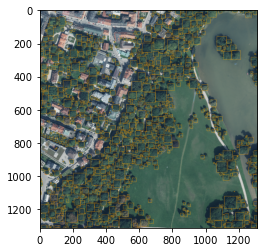

C:\Users\tsunghan.lin\Miniconda3\envs\deepforest\lib\site-packages\rasterio\__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,


In [14]:
for path, sample_image in sample_images.items():
  proj = pyproj.Transformer.from_crs(sample_image['crs'], 4326, always_xy=True)

  predicted_boxes = pd.read_pickle(EXAMPLE_OUTPUT_DIR / 'b' / (path.stem + ".pkl"))
  predicted_boxes.reset_index(drop=True, inplace=True)

  predicted_boxes = run_nms(
    df=predicted_boxes, use_soft_nms=True, sigma=0.7, score_threshold=0.1)

  predicted_boxes = run_nms(
    df=predicted_boxes, use_soft_nms=False, iou_threshold=0.3)

  predicted_boxes = remove_small_overlapping_bbox(predicted_boxes, iou_threshold=0.01)

  geoj = {
      "type": "MultiPolygon",
      "coordinates": []
  }

  for _, r in predicted_boxes.iterrows():
    if (r.xmax - r.xmin > 0 and r.ymax - r.ymin > 0):
      tl = proj.transform(*(sample_image['transform'] * [r.xmin, r.ymin]))
      bl = proj.transform(*(sample_image['transform'] * [r.xmin, r.ymax]))
      br = proj.transform(*(sample_image['transform'] * [r.xmax, r.ymax]))
      tr = proj.transform(*(sample_image['transform'] * [r.xmax, r.ymin]))
      geoj['coordinates'].append([[list(tl) , list(tr), list(br), list(bl), list(tl)]])

  with open(EXAMPLE_OUTPUT_DIR.joinpath(path.stem + ".geojson"), 'w') as outfile:
      json.dump(geoj, outfile)

  image = sample_image['image'][:,:,::-1] # RGB => BGR
  image = visualize.plot_predictions(image, predicted_boxes)
  image = image[:,:,::-1] # BGR => RGB
  plt.imshow(image)
  plt.show()
  out = EXAMPLE_OUTPUT_DIR / (path.stem + SAMPLE_TILE_PATH.suffix)
  with rasterio.open(out, 'w',
                    driver='PNG',
                    height=image.shape[0],
                    width=image.shape[1],
                    count=3,
                    dtype=rasterio.uint8,
                    nodata=0,
                    compress='deflate') as dst:
            dst.write(np.moveaxis(image, -1, 0)) # (H, W, C) -> (C, H, W)